# Lab 3 - Decision Trees

This assignment uses a dataset obtained from the JSE Data Archive that aims at identifying whether there is a statistically significant dependence between gender and biological/activity traits in humans. 

FEATURE DESCRIPTIONS: 

<ul>
<li>Color (Blue, Brown, Green, Hazel, Other)
<li>Age (in years)
<li>YearinSchool (First, Second, Third, Fourth, Other)
<li>Height (in inches)
<li>Miles (distance from home town of student to Ames, IA) 
<li>Brothers (number of brothers)
<li>Sisters (number of sisters)
<li>CompTime (number of hours spent on computer per week)
<li>Exercise (whether the student exercises Yes or No)
<li>ExerTime (number of hours spent exercising per week)
<li>MusicCDs (number of music CDs student owns)
<li>PlayGames (number of hours spent playing games per week)
<li>WatchTV (number of hours spent watching TV per week
</ul>

https://ww2.amstat.org/publications/jse/jse_data_archive.htm

In [1]:
from collections import Counter, defaultdict
from sklearn.tree import DecisionTreeClassifier
from itertools import combinations 
import pandas as pd
import numpy as np
import operator

In [2]:
df = pd.read_csv('Eye_Color.csv')

df.head()

,gender,age,year,eyecolor,height,miles,brothers,sisters,computertime,exercise,exercisehours,musiccds,playgames,watchtv
0,female,18,first,hazel,68.0,195.0,0,1,20.0,Yes,3.0,75.0,6.0,18.0
1,male,20,third,brown,70.0,120.0,3,0,24.0,No,0.0,50.0,0.0,3.0
2,female,18,first,green,67.0,200.0,0,1,35.0,Yes,3.0,53.0,8.0,1.0
3,male,23,fourth,hazel,74.0,140.0,1,1,5.0,Yes,25.0,50.0,0.0,7.0
4,female,19,second,blue,62.0,60.0,0,1,5.0,Yes,4.0,30.0,2.0,5.0


In [3]:
df = df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
df = df.reset_index(drop=True)

# Calculating Gini Index 

In [4]:
def gini(data_counts):
    '''
    calculate the gini index of a node given a list of counts
    '''
    data_sum = sum(data_counts)
    return 1 - sum([(item/data_sum)**2 for item in data_counts])


def gini_group(df, col):
    '''
    calculate the gini index for a split for gender feature
    col is the name of the column with binary values indicating 
    which of the two clusters each observation belongs to
    '''
    d = df.shape[0]
    new_gini_idx = 0
    
    # get col by gender counts
    gender_counts = pd.crosstab(df[col], df['gender']) 
    
    # 2 children nodes since we are only enforcing a binary tree
    for i in range(2): 
        # get gender counts for the child node
        child_gender_counts = gender_counts.iloc[i, :] 
        
        # calculate the new gini index
        d_i = sum(child_gender_counts) 
        new_gini_idx += d_i / d * gini(child_gender_counts)  
            
    return new_gini_idx

**Question 1: How many rows are there in the dataset for males? For females? **  

**Answer:**  
There are 1078 females and 910 males


In [5]:
gender_counts = df.groupby('gender').size()
gender_counts

gender
female    1078
male       910
dtype: int64

**Question 2: What is the Gini Index of this dataset, using males and females as the target classes?**

**Answer**:  
0.4964

In [6]:
base_gini_idx = gini(gender_counts)
base_gini_idx

0.4964292799047807

## Best Split of a Numeric Feature

**Question 3: What is the best split point of the 'height' feature. **  

**Answer**:  
group 1: $(-\infty, 68]$  
group 2: $(68, \infty)$

In [7]:
heights = list(sorted(df['height'].unique()))
min_heights = heights[0] - 1
max_heights = heights[-1] + 1

best_split_criteria, best_gini_idx = 0, None # initialization

for criteria in heights:
    df['height_grouping'] = pd.cut(df['height'], [min_heights, criteria, max_heights], right=True)
    new_gini_idx = gini_group(df, 'height_grouping')
    if (best_gini_idx is None) or (new_gini_idx < best_gini_idx):
        best_split_criteria, best_gini_idx = criteria, new_gini_idx
        
best_split_criteria  

68.0

**Question 4: What is the Gini Index of this best split?**  

**Answer**:  
0.2655

In [8]:
best_gini_idx

0.26552881207029189

**Question 5: How much does this partitioning reduce the Gini Index over that of the overall dataset?**  

**Answer**:  
0.2309

In [9]:
base_gini_idx - best_gini_idx

0.23090046783448881

**Question 6: How many 'female' rows are below your best split point? 'male' rows?**  

**Answer**:  
No. females: 905, No. males: 142

In [10]:
df[df['height'] <= 68].groupby('gender').size()

gender
female    905
male      142
dtype: int64

**Question 7: How many 'female' rows are above your best split point? 'male' rows?**  

**Answer**:  
Number of females: 173, Number of males: 768

In [11]:
df[df['height'] > 68].groupby('gender').size()

gender
female    173
male      768
dtype: int64

Recall that, to calculate the best split of this numeric field, you'll need to order your data by 'height', then consider the midpoint between each pair of consecutive heights as a potential split point, then calculate the Gini Index for that partitioning. You'll want to keep track of the best split point and its Gini Index (remember that you are trying to minimize the Gini Index). 

There are a lot of ways to do this. Some are very fast, others very slow. One tip to make this run quickly is, as you consecutively step through the data and calculate the Gini Index of each possible split point, keep a running total of the number of rows for each candidate that are located above and below the split point. 

Some Python tips: 

* Counter(), from the collections module, is a special dictionary for counting values of a key
* zip() lets you concatenate lists into a list of tuples (for example, if we have a list of the candidates and a list of transaction amounts, zip(candidate_list, transaction_amount) would give us a list of (candidate, transaction amount) pairs

## Best Split of a Categorial Variable

**Question 8: How many possible splits are there of the eyecolor feature?**

In [12]:
eyecolors = list(sorted(df['eyecolor'].unique()))
color_combos = [colors for colors in combinations(eyecolors, 2)]
color_combos = color_combos + [colors for colors in combinations(eyecolors, 1)]
len(color_combos)

15

**Question 9: Which split of eyecolor best splits the female and male rows, as measured by the Gini Index?**  

**Answer**:  
group 1: green  
group 2: brown, blue, hazel, other

In [13]:
best_split_criteria, best_gini_idx = 0, None # initialization

for criteria in color_combos:
    df['eyecolor_grouping'] = df['eyecolor'].map(lambda x: x in criteria)
    new_gini_idx = gini_group(df, 'eyecolor_grouping')
    if (best_gini_idx is None) or (new_gini_idx < best_gini_idx):
        best_split_criteria, best_gini_idx = criteria, new_gini_idx

best_split_criteria

('green',)

**Question 10: What is the Gini Index of this best split?**   

**Answer**:  
0.4931

In [15]:
best_gini_idx

0.49309157295097772

In [14]:
# VALIDATION
green = df[df['eyecolor'] == 'green'].groupby('gender').size()
green_sum = green.sum()
green_gini = green_sum/df.shape[0]*(
    1 - ((green['female']/green_sum)**2 + (green['male']/green_sum)**2))

non_green = df[~(df['eyecolor'] == 'green')].groupby('gender').size()
non_green_sum = non_green.sum()
non_green_gini = non_green_sum/df.shape[0]*(
    1 - ((non_green['female']/non_green_sum)**2 + (non_green['male']/non_green_sum)**2))

non_green_gini + green_gini

0.49309157295097772

**Question 11: How much does this partitioning reduce the Gini Index over that of the overall data set?**  

**Answer**:  
3.338E-3

In [16]:
base_gini_idx - best_gini_idx

0.0033377069538029769

**Question 12: How many 'female' rows and 'male' rows are in your first partition? How many 'female' rows and 'male' rows are in your second partition?**  

**Answer**:  
1st partition (eyecolor green):   
Number of females: 190, number of males: 107  

2nd partition (eyecolor everything else):   
Number of female: 888, number of males: 803  

In [17]:
df.groupby([df['eyecolor'] == 'green', 'gender']).size()

eyecolor  gender
False     female    888
          male      803
True      female    190
          male      107
dtype: int64

Python tip: the combinations function of the itertools module allows you to enumerate combinations of a list

## Training a decision tree

**Question 13: Using all of the features in the original dataframe read in at the top of this notebook, train a decision tree classifier that has a depth of three (including the root node and leaf nodes). What is the accuracy of this classifier on the training data?**  

**Answer**:  
0.8647

In [18]:
clf = DecisionTreeClassifier(max_depth=3) # depth 3 including node and leaf nodes
df_train = df.drop(['gender', 'height_grouping', 'eyecolor_grouping'], axis=1)
df_train = pd.get_dummies(df_train)
df_target = df['gender']
clf.fit(df_train, df_target)

clf.score(df_train, df_target)

0.86468812877263579

**Question 14: Using the following code snippet, export your decision tree to graphviz and visualize it. In your write-up, write down the interpretation of the rule at each node which is used to perform the splitting.**  

**Answer**:  
* root node: if a person's height is less than or equeal to 68.5 inches, go to the left node, otherwise go to the right node   
* left node: if a person spends more than or equal to 7.75 hours playing games per week and is taller than 65.5 inch, then classify as male, otherwise classify them as female  
* right node: if a person plays games for less than or equal to 2.5 hours a week and is shorter than 70.5 inch then classify as female, otherwise classify as male
* the denser the color, the purer the data

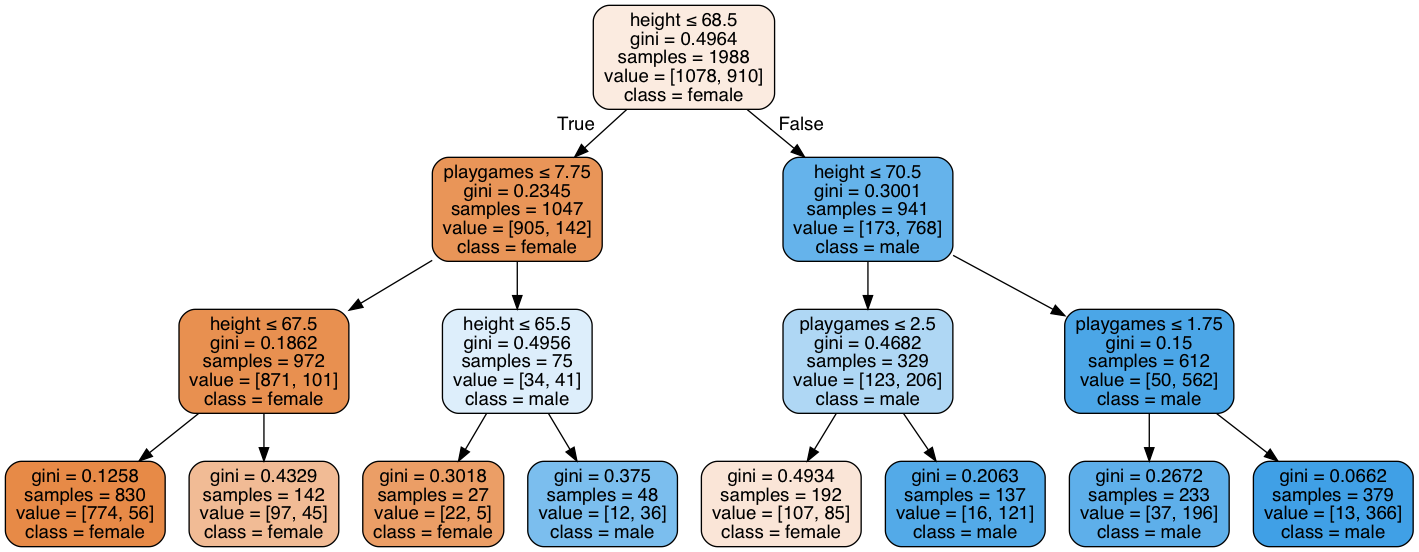

In [19]:
from IPython.display import Image  
import pydotplus 
import sklearn
features = list(df_train.columns)

dot_data = sklearn.tree.export_graphviz(clf, out_file=None, 
                                        feature_names=features, 
                                        class_names=['female','male'], 
                                        filled=True, rounded=True, special_characters=True) 
graph = pydotplus.graph_from_dot_data(dot_data) 
graph.write_pdf('name.pdf')
Image(graph.create_png())

**Question 15: For each of your leaf nodes, specify the percentage of 'female' rows in that node (out of the total number of rows at that node).**

In [20]:
def get_leaf_indices(tree, current_node_idx):
    # assuming enforced balanced binary tree
    if (tree.children_left[current_node_idx] == -1) & (tree.children_right[current_node_idx] == -1):
        return [current_node_idx]
    else:
        left = tree.children_left[current_node_idx]
        right = tree.children_right[current_node_idx]
        return get_leaf_indices(tree, left) + get_leaf_indices(tree, right)

leaf_indices = get_leaf_indices(clf.tree_, 0)
leaf_values = clf.tree_.value[leaf_indices]

female_percents = [leaf[0] / sum(leaf) *100 for [leaf] in leaf_values]

print('percentage of female rows from left to right: ')
print(', '.join(['{:.3f}%'.format(female_percent) for female_percent in female_percents]))

percentage of female rows from left to right: 
93.253%, 68.310%, 81.481%, 25.000%, 55.729%, 11.679%, 15.880%, 3.430%


See this notebook for the basics of training a decision tree in scikit-learn and exporting the outputs to view in graphviz: http://nbviewer.ipython.org/gist/tebarkley/b68c04d9b31e64ce6023

Scikit-learn classifiers require class labels and features to be in numeric arrays. As such, you will need to turn your categorical features into numeric arrays using DictVectorizer. This is a helpful notebook for understanding how to do this: http://nbviewer.ipython.org/gist/sarguido/7423289. You can turn a pandas dataframe of features into a dictionary of the form needed by DictVectorizer by using df.to_dict('records'). Make sure you remove the class label first (in this case, gender). If you use the class label as a feature, your classifier will have a training accuracy of 100%! The example notebook link also shows how to turn your class labels into a numeric array using sklearn.preprocessing.LabelEncoder().